In [191]:
from os import getenv

from dotenv import load_dotenv

load_dotenv()
DATA = getenv("DATA_DIRECTORY")

In [192]:
from scipy.io.wavfile import read

rate, data = read(f"{DATA}/dataset2/audio/FS_Lick4_FN.wav")
data = data[:]
length = data.shape[0] / rate
signal = data / data.max()

<ipython-input-192-1fefc3b6d14b>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = read(f"{DATA}/dataset2/audio/FS_Lick4_FN.wav")


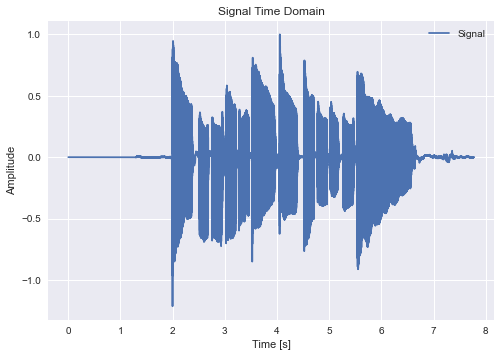

In [193]:
from numpy import linspace
from matplotlib import pyplot as plt

plt.title("Signal Time Domain")
plt.plot(linspace(0, length, data.shape[0]), signal, label="Signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

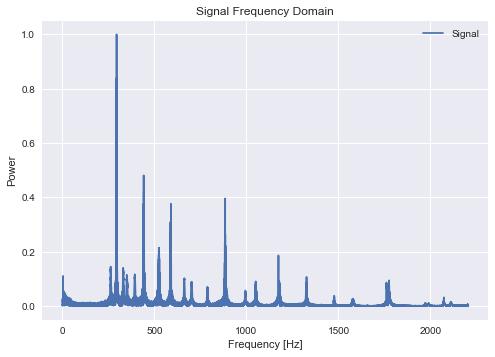

In [194]:
from scipy.fft import rfft as fft, rfftfreq as fftfreq

xf = fftfreq(round(rate * length), 1 / rate)[:int(rate * length // 20)]
yf = fft(signal)[:int(rate * length // 20)]

plt.title("Signal Frequency Domain")
plt.plot(xf, abs(yf / max(yf)), label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()

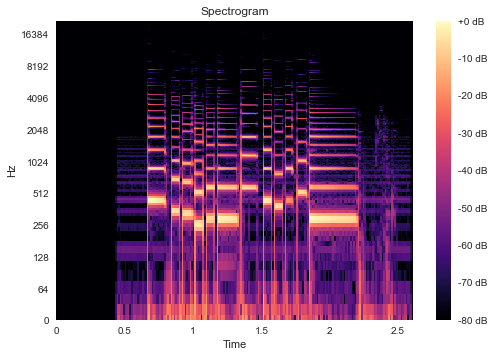

In [195]:
from scipy.signal import stft
from librosa import amplitude_to_db
from librosa.display import specshow
from numpy import max as amax, abs

frequency_domain, time_domain, spectrum = stft(signal, fs=rate, nperseg=2048, noverlap=512)
fig, ax = plt.subplots()
img = specshow(amplitude_to_db(abs(spectrum), ref=amax), sr=rate, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [196]:
from numpy import sqrt, zeros_like, angle, exp, mod, pi, mean, abs, sum, log, array

def half_wave(x, norm=sum):
    return (x + norm(x)) / 2

def spectral_flux(spec, mag, phase, n):
    return sum(half_wave((mag[:, n] - mag[:, n - 1]) ** 2))

def rectified_complex_domain(spec, mag, phase, n):
    return sum(abs(spec[:, n] - mag[:, n - 1] * exp(1j * (2 * phase[:, n - 1] - phase[:, n - 2]))) * (mag[:, n] >= mag[:, n - 1]))

def weighted_phase_deviation(spec, mag, phase, n):
    return mean(abs(spec[:, n] * (mod(phase[:, n] - 2 * phase[:, n - 1] + phase[:, n - 2] + pi, 2 * pi) - pi)))

def spectral_difference(spec, mag, phase, n):
    return sum(abs(mag[:, n] ** 2 - mag[:, n - 1] ** 2))

def high_frequency_content(spec, mag, phase, n):
    return mean(mag[:, n] ** 2 * range(len(mag[:, n])))

def modified_kullback_leibler(spec, mag, phase, n):
    return sum(mag[:, n] * log(1 + mag[:, n] / (mag[:, n - 1] + 1e-7)))

def goto(spec, mag, phase, n):
    return sum(array([max(mag[k, n], mag[k + 1, n]) * (min(mag[k, n], mag[k + 1, n]) > max(mag[k - 1, n - 1], mag[k, n - 1], mag[k + 1, n - 1])) for k in range(1, len(mag[:, n]) - 1)]))

from functools import reduce

def onsets(arr, fs=44100, t_=5e-3*2, ke=100, kt=12e-5, p=20):
    t = fs * t_
    all_sum = sum(arr ** 2) / len(arr)

    def e(n):
        return arr[n] ** 2 / t
    
    def filt(l, n):
        if min(e(n - i) for i in range(1, p)) < (en := e(n)) and all_sum < ke * en and kt * fs < (n - l[1]):
            return [*l[0], n], n
        return l
    
    return array(list(reduce(filt, range(1, len(arr)), ([], 1))[0]))

from scipy.fft import fft, fftfreq
from scipy.signal.windows import hamming
from numpy import array, linspace

def stft(s, fs, frame_size, hop_size, window=hamming):
    frame_sample = int(frame_size * fs)
    hop_sample = int(hop_size * fs)
    window_ = window(frame_sample + 1)[:-1]
    spec = array([fft(window_ * s[i:i + frame_sample]) for i in range(0, len(s) - frame_sample, hop_sample)])
    time = linspace(0, len(s) / fs, len(spec))
    freq = linspace(0, fs / 2, len(spec[0]))
    return freq, time, spec.transpose()

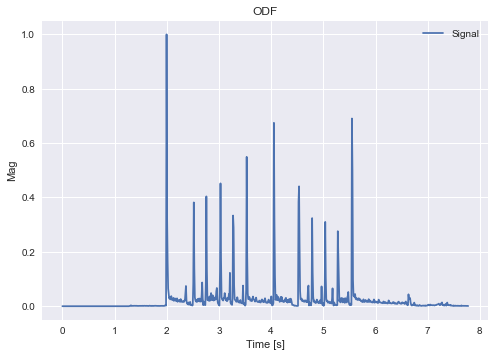

In [197]:
hop_size = 5e-3*2
freq_domain, time_domain, spectrum = stft(signal, rate, hop_size=hop_size, frame_size=8e-3*2)
mag, phase = abs(spectrum), angle(spectrum)
time = linspace(0, length, len(time_domain))
functions = (rectified_complex_domain, goto, modified_kullback_leibler, weighted_phase_deviation)
mean_f = 0
for idx, f in enumerate(functions):
    raw_detections = abs(array([f(spectrum, mag, phase, i) for i in range(len(time_domain))]))
    detections = raw_detections / max(raw_detections)
    mean_f += detections
detections = mean_f / len(functions)
plt.plot(time, detections, label="Signal")
plt.legend()
plt.title(f"ODF")
plt.xlabel("Time [s]")
plt.ylabel("Mag")
plt.show()

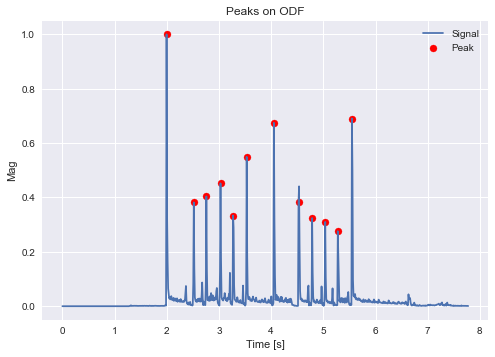

In [198]:
peaks = onsets(detections, rate, t_=hop_size * 1.5, ke=100, kt=12e-5)
plt.plot(time, detections, label="Signal")
plt.scatter(time, [detections[t] if t in peaks else None for t in range(len(time_domain))], label="Peak", color='red')
plt.legend()
plt.title(f"Peaks on ODF")
plt.xlabel("Time [s]")
plt.ylabel("Mag")
plt.show()

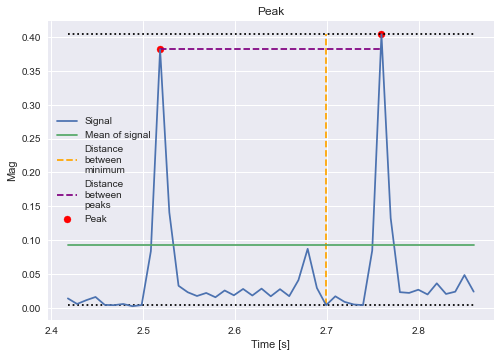

In [217]:
from numpy import argmin
offset = 10
idx = 2
x = time[peaks[idx - 1] - offset:peaks[idx] + offset + 1]
y = detections[peaks[idx - 1] - offset:peaks[idx] + offset + 1]
m = sqrt(mean(y ** 2))
plt.plot(x, y, label="Signal")
plt.plot(x, [m for _ in range(len(x))], label="Mean of signal")
plt.vlines(x[offset + argmin(detections[peaks[idx - 1]:peaks[idx] - 1])], min(detections[peaks[idx - 1]:peaks[idx] - 1]), detections[peaks[idx]], colors='orange', linestyles='--', label='Distance\nbetween\nminimum')
plt.hlines([min(detections[peaks[idx - 1]:peaks[idx] - 1]), detections[peaks[idx]]], [x[0], x[0]], [x[-1], x[-1]], colors=['black', 'black'], linestyles=[':', ':'])
plt.hlines(detections[peaks[idx - 1]], time[peaks[idx - 1]], time[peaks[idx]], colors='purple', linestyles='--', label='Distance\nbetween\npeaks')
plt.scatter(x, [y[t] if y[t] == detections[peaks[idx]] or y[t] == detections[peaks[idx - 1]] else None for t in range(len(y))], label="Peak", color='red')
plt.legend(loc=6)
plt.title(f"Peak")
plt.xlabel("Time [s]")
plt.ylabel("Mag")
plt.show()

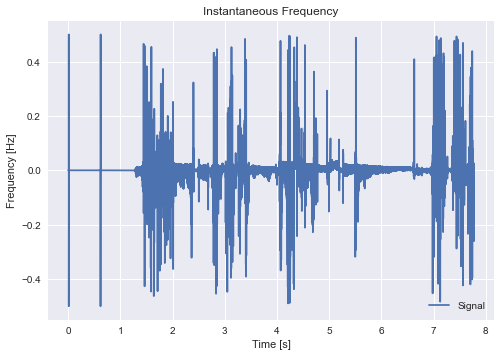

In [201]:
from numpy import abs, angle, unwrap, diff, pi, array
from scipy.signal import hilbert

analytic_signal = hilbert(signal)
amplitude_envelope = abs(analytic_signal)
instantaneous_phase = unwrap(angle(analytic_signal))
instantaneous_frequency = diff(instantaneous_phase) / (2 * pi)
plt.title("Instantaneous Frequency")
plt.plot(linspace(0, length, len(instantaneous_frequency)), instantaneous_frequency, label="Signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [202]:
from numpy import ceil, log2, exp, pi, arange, array, sqrt
from scipy.fft import fft
from scipy.signal.windows import hamming
from scipy.sparse import coo_matrix, vstack

def cqt_kern(fs, bins=12, fmin=32, fmax=84*32, window=hamming):
    K = int(ceil(bins * log2(fmax / fmin)))
    Q = 1 / (2 ** (1 / bins) - 1) / 1.5
    fft_len = int(2 ** ceil(log2(ceil(Q * fs / fmin))))
    res = []
    for k in range(K, 0, -1):
        N = int(ceil(Q * fs / (fmin * 2 ** ((k) / bins))))
        tmp_kernel = window(N) / N * exp(2 * pi * 1j * Q * arange(N) / N)
        spec_kern = fft(tmp_kernel, fft_len)
        spec_kern[abs(spec_kern) <= 0.05] = 0
        res += [coo_matrix(spec_kern)]
    kernel = vstack(res[::-1]).tocsc().transpose().conj() / fft_len
    return kernel

def cqt(x, fs, hop_size=512, bins=12, fmin=32, fmax=84*48, window=hamming):
    kern = cqt_kern(fs, bins, fmin, fmax, window)
    return array(range(0, len(x) - kern.shape[0], hop_size)) / fs, array(range(1, 1 + int(ceil(bins * log2(fmax / fmin))))) * bins + fmin, array([fft(x[i:i + kern.shape[0]], kern.shape[0]) * kern for i in range(0, len(x) - kern.shape[0], hop_size)])

/home/andreeff/.cache/pypoetry/virtualenvs/diploma-5iax5lmd-py3.9/lib/python3.9/site-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


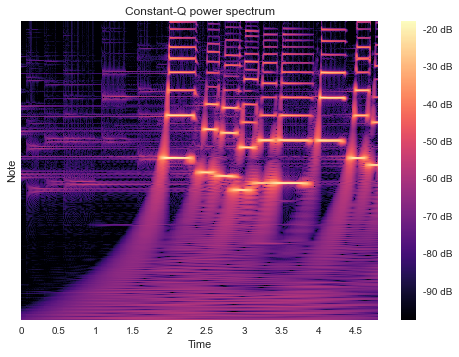

In [203]:
from librosa import amplitude_to_db
from librosa.display import specshow
from matplotlib import pyplot as plt

time_domain, freq_domain, spectrum = cqt(signal, rate, bins=84, hop_size=512)
spectrum = spectrum.transpose()
fig, ax = plt.subplots()
img = specshow(amplitude_to_db(abs(spectrum)), sr=rate, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

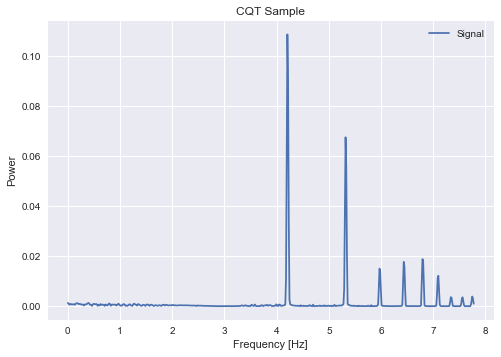

In [204]:
plt.title("CQT Sample")
plt.plot(linspace(0, length, len(spectrum[:, 187])), abs(spectrum[:, 180]), label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()

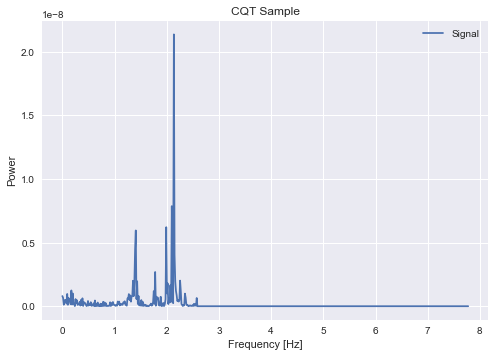

In [205]:
from scipy.signal import resample
from numpy import append, zeros

res1 = abs(spectrum[:, 189])
res2 = abs(resample(res1, len(res1) // 2))
res3 = abs(resample(res1, len(res1) // 3))
res2 = append(res2, zeros(len(res1) - len(res2)))
res3 = append(res3, zeros(len(res1) - len(res3)))
res = res1 * res2 * res3
plt.title("CQT Sample")
plt.plot(linspace(0, length, len(res)), res, label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()

In [206]:
from scipy.signal import decimate, resample
from numpy import append, zeros, argmax, logspace

res1 = abs(spectrum[:, 59])
res2 = abs(decimate(res1, 2))
res3 = abs(decimate(res1, 3))
res2 = append(res2, zeros(len(res1) - len(res2)))
res3 = append(res3, zeros(len(res1) - len(res3)))
plt.title("CQT Sample")
plt.plot(frequency_domain, res1, label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()
plt.title("CQT Sample DS 2")
plt.plot(frequency_domain, res2, label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()
plt.title("CQT Sample DS 3")
plt.plot(frequency_domain, res3, label="Signal")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()
res = res1 * res2 * res3
plt.title("CQT Sample Prod")
plt.plot(frequency_domain, res, label="Signal")
plt.scatter(frequency_domain, [r if r == max(res) else None for r in res], label='Peak', color='red')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1025,) and (587,)